In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import math

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads) -> None:
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads

        # Q, K, V projections matrix

        self.W_q = nn.Linear(d_model, d_model) # d_model -> d_model
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        # Output projection matrix
        self.W_o = nn.Linear(d_model, d_model)

        # Softmax
        self.softmax = nn.Softmax(dim=-1) # dim=-1 means last dimension

    def forward(self, q, k, v, mask=None):
        batch, time, dimension = q.shape # q.shape = (batch, time, d_model)
        n_d = self.d_model // self.num_heads

        # self.d_model is the dimension of the model, n_d is the dimension of each head
        # arranging dimensions evenly across heads

        q, k, v = self.W_q(q), self.W_k(k), self.W_v(v)
        # projecting q, k, v to target space

        q = q.view(batch, time, self.num_heads, n_d).permute(0, 2, 1, 3)
        k = k.view(batch, time, self.num_heads, n_d).permute(0, 2, 1, 3)
        v = v.view(batch, time, self.num_heads, n_d).permute(0, 2, 1, 3)
        # .view() is used to reshape the tensor without changing the data
        # .permute() is used to rearrange the dimensions of the tensor
        # view: (batch, time, d_model) -> (batch, time, num_heads, n_d)
        # permute: (batch, time, num_heads, n_d) -> (batch, num_heads, time, n_d)

        # time * n_d is the dimension of the query and key vectors
        # reshape for parallel computation

        score = q @ k.transpose(2, 3) / math.sqrt(n_d)
        # @ is matrix multiplication or dot product
        # * is element-wise multiplication
        # / math.sqrt(n_d) is scaling factor to normalize the dot product

        # mask = torch.tril(torch.ones(time, time, dtype=bool))
        # torch.triu() is used to create a triangular matrix with upper triangular elements
        # torch.tril() is used to create a triangular matrix with lower triangular elements
        # torch.ones() is used to create a tensor of ones

        if mask is not None:
            mask = mask.unsqueeze(1)  # Add a dimension for the heads
            score = score.masked_fill(mask == 0, float('-inf'))
        score = self.softmax(score) @ v

        score = score.permute(0, 2, 1, 3).contiguous().reshape(batch, time, dimension)
        # .contiguous() is used to make the tensor contiguous in memory

        return self.W_o(score)

In [3]:
# 一行代码测试
attention = MultiHeadAttention(d_model=512, num_heads=8)
output = attention(torch.randn(2, 5, 512), torch.randn(2, 5, 512), torch.randn(2, 5, 512))
print(f"快速测试结果: 输入形状 (2, 5, 512) -> 输出形状 {output.shape}")

快速测试结果: 输入形状 (2, 5, 512) -> 输出形状 torch.Size([2, 5, 512])


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model) # Initialize positional encoding matrix
        position = torch.arange(0, max_len).unsqueeze(1) # [max_len, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                           (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term) # sin for even indices
        pe[:, 1::2] = torch.cos(position * div_term) # cos for odd indices
        self.register_buffer('pe', pe.unsqueeze(0)) # [1, max_len, d_model]

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]
        # [:, :x.size(1)] means to get all the rows, and the first x.size(1) columns

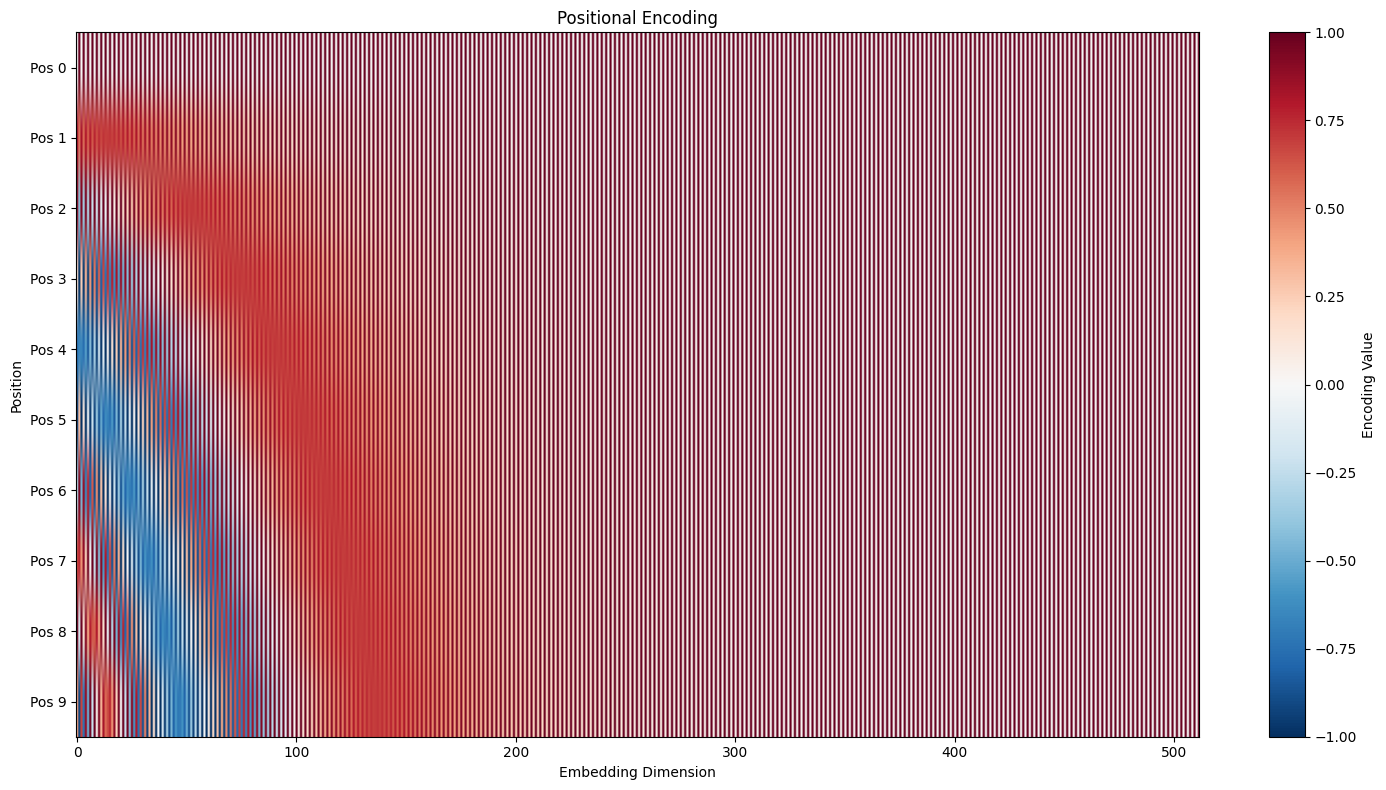

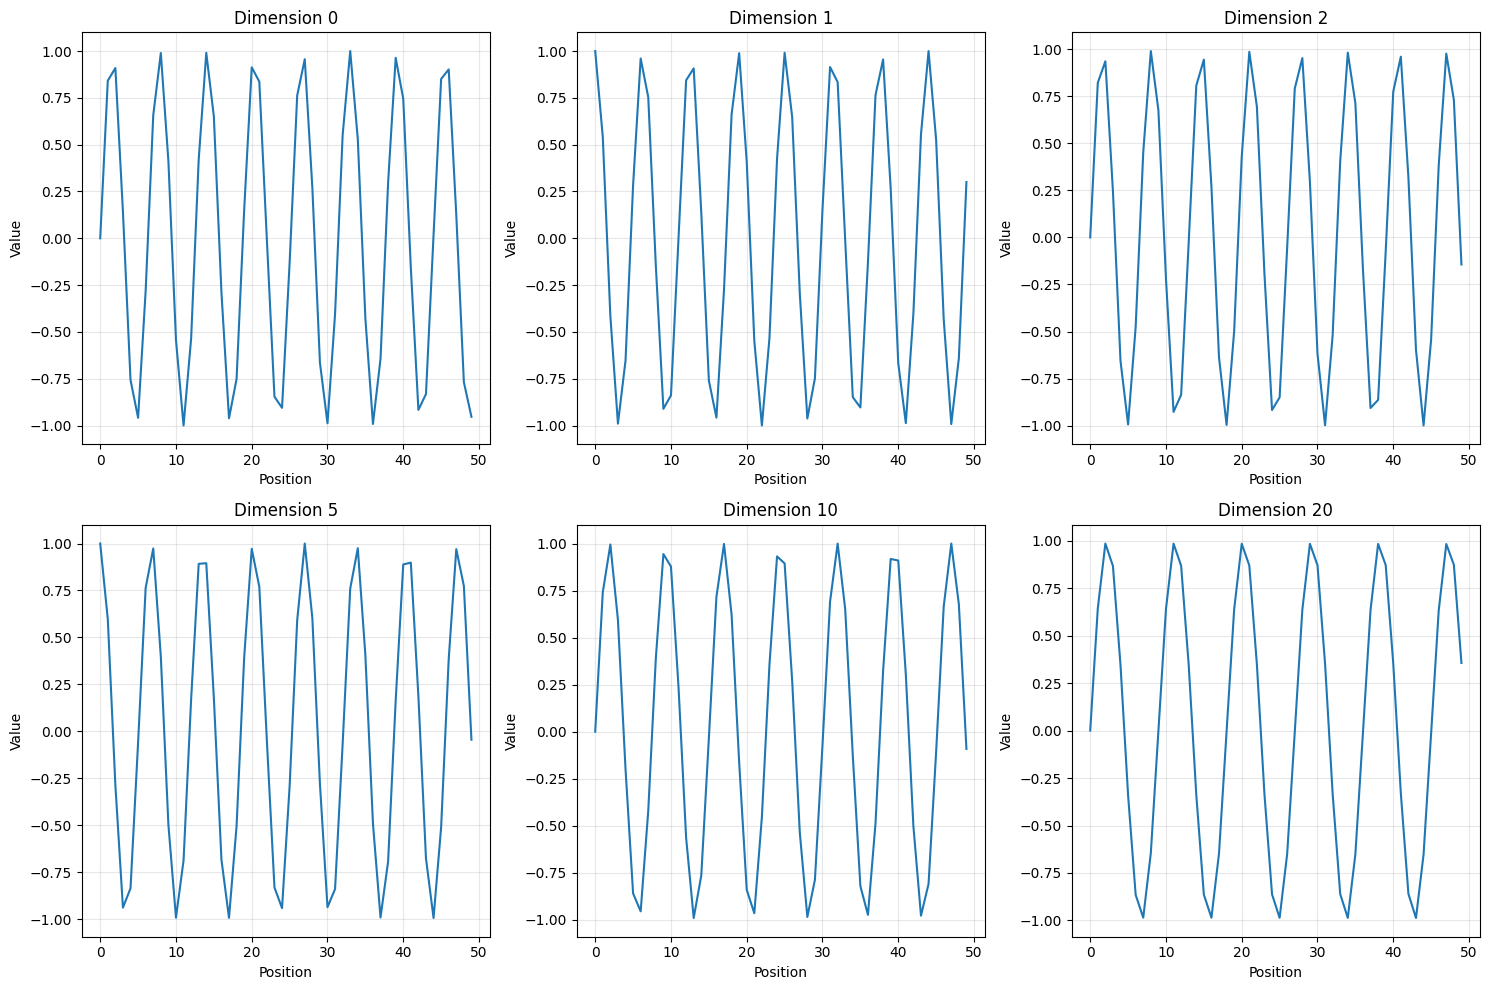

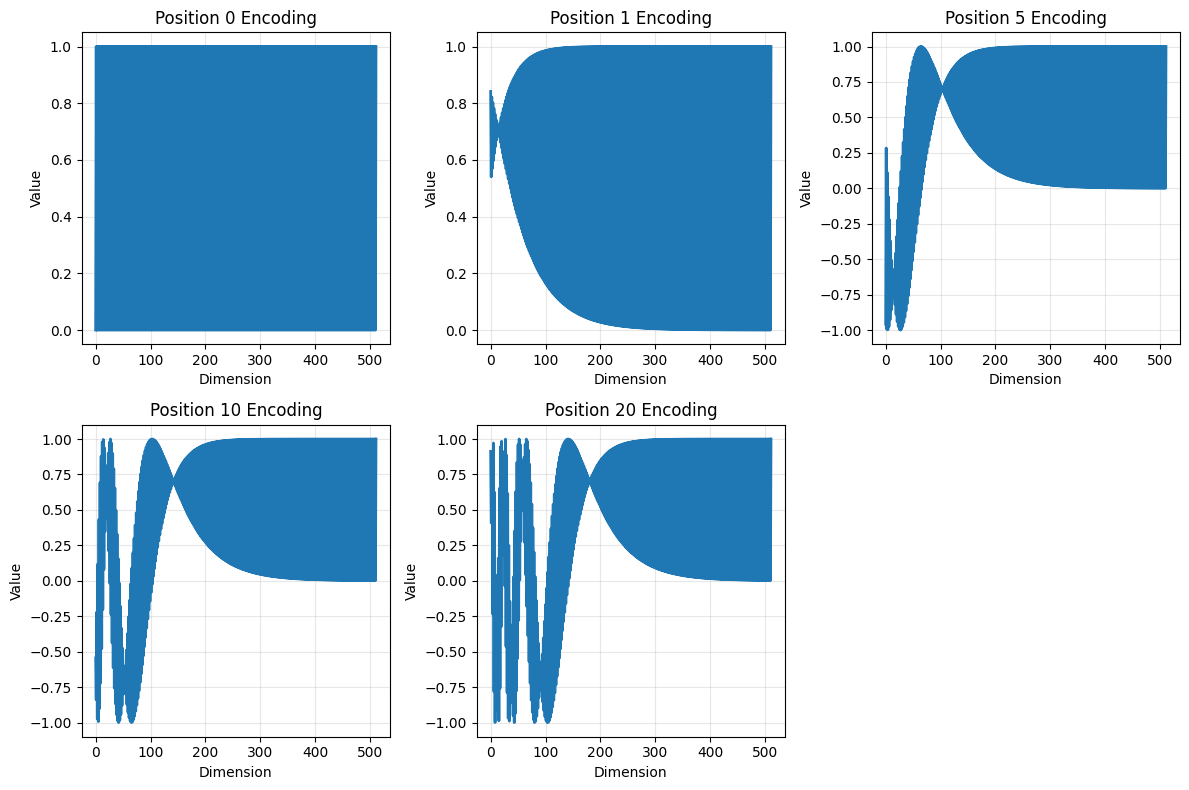

In [13]:
import torch
from torch import nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import numpy as np

def plot_positional_encoding_heatmap(d_model=512, max_len=100):
    """绘制位置编码的热力图"""
    # 使用您编写的PositionalEncoding模块
    pos_encoding = PositionalEncoding(d_model, max_len)

    # 创建测试输入
    x = torch.zeros(1, max_len, d_model)  # batch=1, seq_len=max_len, d_model=d_model

    # 获取位置编码
    pe = pos_encoding(x).squeeze(0)  # 移除batch维度

    # 可视化前10个位置的编码（使用matplotlib）
    plt.figure(figsize=(15, 8))
    plt.imshow(pe[:10, :].numpy(), cmap='RdBu_r', aspect='auto')
    plt.colorbar(label='Encoding Value')
    plt.title('Positional Encoding')
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Position')
    plt.yticks(range(10), [f'Pos {i}' for i in range(10)])
    plt.tight_layout()
    plt.show()

    # 可视化不同维度的编码模式
    plt.figure(figsize=(15, 10))
    dimensions_to_show = [0, 1, 2, 5, 10, 20]
    for i, dim in enumerate(dimensions_to_show):
        plt.subplot(2, 3, i+1)
        plt.plot(pe[:, dim].numpy())
        plt.title(f'Dimension {dim}')
        plt.xlabel('Position')
        plt.ylabel('Value')
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 可视化特定位置的编码模式
    plt.figure(figsize=(12, 8))
    positions = [0, 1, 5, 10, 20]
    for i, pos in enumerate(positions):
        plt.subplot(2, 3, i+1)
        plt.plot(range(d_model), pe[pos].numpy(), linewidth=2)
        plt.title(f'Position {pos} Encoding')
        plt.xlabel('Dimension')
        plt.ylabel('Value')
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return pe

# 绘制热力图
positional_encoding = plot_positional_encoding_heatmap(d_model=512, max_len=50)

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-5):
        super().__init__()
        self.d_model = d_model
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        
    def forward(self, x):
        # 计算均值和方差
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        
        # 归一化
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        
        # 缩放和偏移
        return self.gamma * x_norm + self.beta

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, hidden, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x 

In [ ]:
class TransformerEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model, max_len, dropout=0.1):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model, padding_idx=1)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        tok_emb = self.token_embedding(x)
        pos_emb = self.positional_encoding(x)
        return self.dropout(tok_emb + pos_emb)

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, hidden, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.ffn = FeedForward(d_model, hidden, dropout)
        self.norm2 = LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output = self.attention(x, x, x, mask)
        x = x + self.dropout1(attn_output) # residual connection
        x = self.norm1(x)
        ffn_output = self.ffn(x)
        x = x + self.dropout2(ffn_output)
        x = self.norm2(x)
        return x

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, hidden, dropout=0.1):
        super().__init__()
        self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)

        self.cross_attention = MultiHeadAttention(d_model, num_heads)
        self.norm2 = LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)
        
        self.ffn = FeedForward(d_model, hidden, dropout)
        self.norm3 = LayerNorm(d_model)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        attn_output = self.self_attention(x, x, x, tgt_mask)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)

        attn_output = self.cross_attention(x, enc_output, enc_output, src_mask)
        x = x + self.dropout2(attn_output)
        x = self.norm2(x)
        
        ffn_output = self.ffn(x)
        x = x + self.dropout3(ffn_output)
        x = self.norm3(x)
        return x

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, max_len, num_layers, num_heads, hidden, dropout=0.1):
        super().__init__()
        self.embedding = TransformerEmbedding(vocab_size, d_model, max_len, dropout)
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, hidden, dropout) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x, mask)
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, max_len, num_layers, num_heads, hidden, dropout=0.1):
        super().__init__()
        self.embedding = TransformerEmbedding(vocab_size, d_model, max_len, dropout)
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, hidden, dropout) for _ in range(num_layers)])
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x, enc_output, src_mask, tgt_mask)
        x = self.fc(x)
        return x

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_pad_idx, tgt_pad_idx, enc_vocab_size, dec_vocab_size, d_model, max_len, num_layers, num_heads, hidden, dropout=0.1):
        super().__init__()
        self.encoder = Encoder(enc_vocab_size, d_model, max_len, num_layers, num_heads, hidden, dropout)
        self.decoder = Decoder(dec_vocab_size, d_model, max_len, num_layers, num_heads, hidden, dropout)
        self.src_pad_idx = src_pad_idx
        self.tgt_pad_idx = tgt_pad_idx

    def make_pad_mask(self, q, k, pad_idx_q, pad_idx_k):
        len_q, len_k = q.size(1), k.size(1)
        pad_mask_q = (q != pad_idx_q).unsqueeze(1).unsqueeze(3)
        pad_mask_k = (k != pad_idx_k).unsqueeze(1).unsqueeze(2)
        pad_mask = pad_mask_q & pad_mask_k
        return pad_mask
    
    def make_causal_mask(self, q, k):
        len_q, len_k = q.size(1), k.size(1)
        casual_mask = torch.tril(torch.ones(len_q, len_k)).type(torch.bool)
        return casual_mask
    
    def forward(self, src, tgt):
        src_mask = self.make_pad_mask(src, src, self.src_pad_idx, self.src_pad_idx)
        tgt_mask = self.make_pad_mask(tgt, tgt, self.tgt_pad_idx, self.tgt_pad_idx) & self.make_causal_mask(tgt, tgt)
        src_tgt_mask = self.make_pad_mask(tgt, src, self.tgt_pad_idx, self.src_pad_idx)

        enc_output = self.encoder(src, src_mask)
        dec_output = self.decoder(tgt, enc_output, src_tgt_mask, tgt_mask)
        return dec_output